In [9]:
from load_data.utils import process_all_documents
from load_data import load_dataframe, process_text
from plots import plot_counter_lemmas
from plots.topics import interactive_exploration, plot_topics, plot_similarities
from topic_modeling.utils import check_coherence_for_topics_num
from topic_modeling.lda_model import find_best_model, find_best_topics_num
from topic_modeling.topic_probs import (
    get_similarities,
    get_topic_probs,
    calculate_distance_matrix,
    calculate_linkage_matrix,
    topic_probs_by_column_binded,
    tsne_dim_reduction,
)

import pandas as pd
from collections import Counter

In [10]:
necp_processed = pd.read_csv('./necp_reports/necp_processed.csv', index_col = 0)
necp_processed.drop(['start_page', 'end_page', 'start_text', 'end_text'], axis = 1, inplace = True)
necp_processed.drop(necp_processed[necp_processed.isnull()["text"]].index, axis = 0, inplace = True)

In [11]:
df = pd.DataFrame(columns=["paragraph", "country", "text_path", "text", "tokens", "lemmas"])
df["country"] = necp_processed["country"]
df["text"] = necp_processed["text"]
df["paragraph"] = [row[1]["subsection"] if row[1]["subsection"] in ["Overview and Process for Establishing the Plan", "Impact Assessment of Planned Policies and Measures"] else row[1]["energy_union_dimension"] for row in necp_processed.iterrows()]
processed_df = process_text(df, spacy_model="en_core_web_md")

In [12]:
paragraphs = ["Overview and Process for Establishing the Plan",
              "Impact Assessment of Planned Policies and Measures",
              "Decarbonisation",
              "Energy efficiency",
              "Energy security",
              "Internal market",
              "R&I and Competitiveness"]
common_words = {}

### Paragraph: Overview and Process for Establishing the Plan

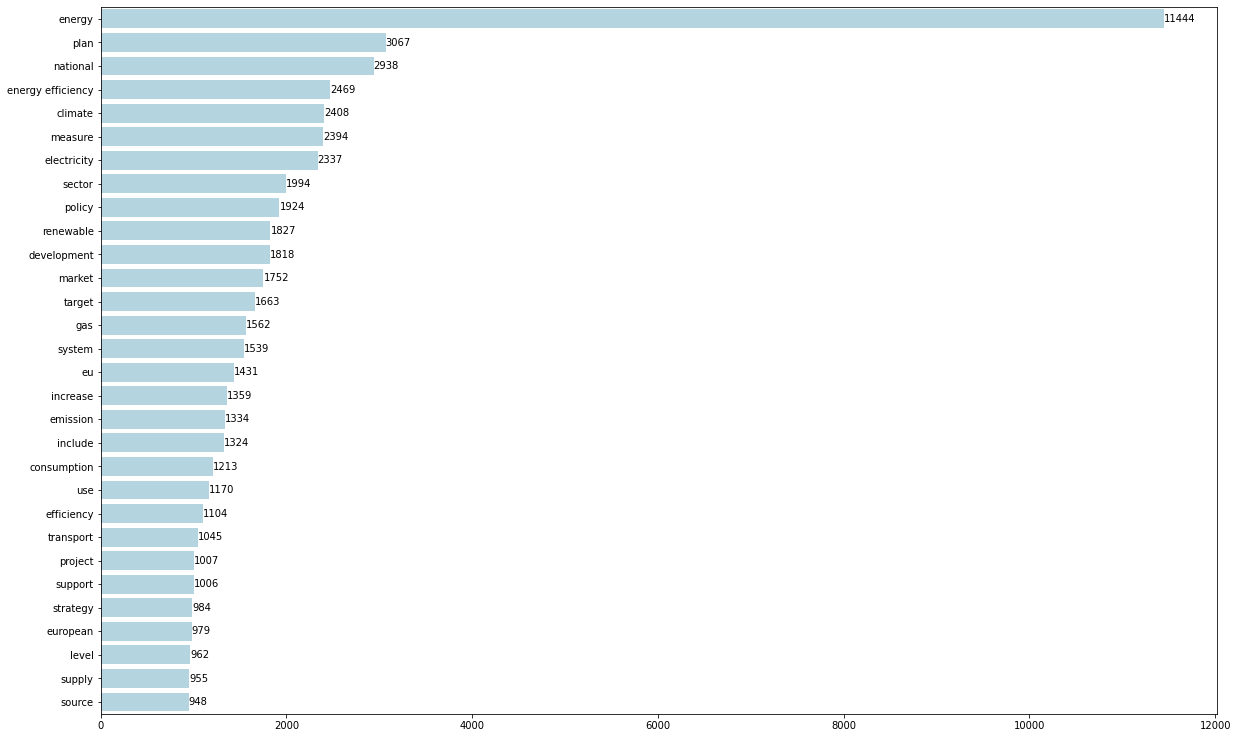

In [13]:
filter_dict = {'paragraph':paragraphs[0]}
plot_counter_lemmas(processed_df, filter_dict)

In [14]:
filtered_lemmas = processed_df.loc[(processed_df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]["lemmas"]
counter = Counter(filtered_lemmas.sum()).most_common(3)
common_words[paragraphs[0]] = [word for word, cnt in counter]

### Paragraph: Impact Assessment of Planned Policies and Measures

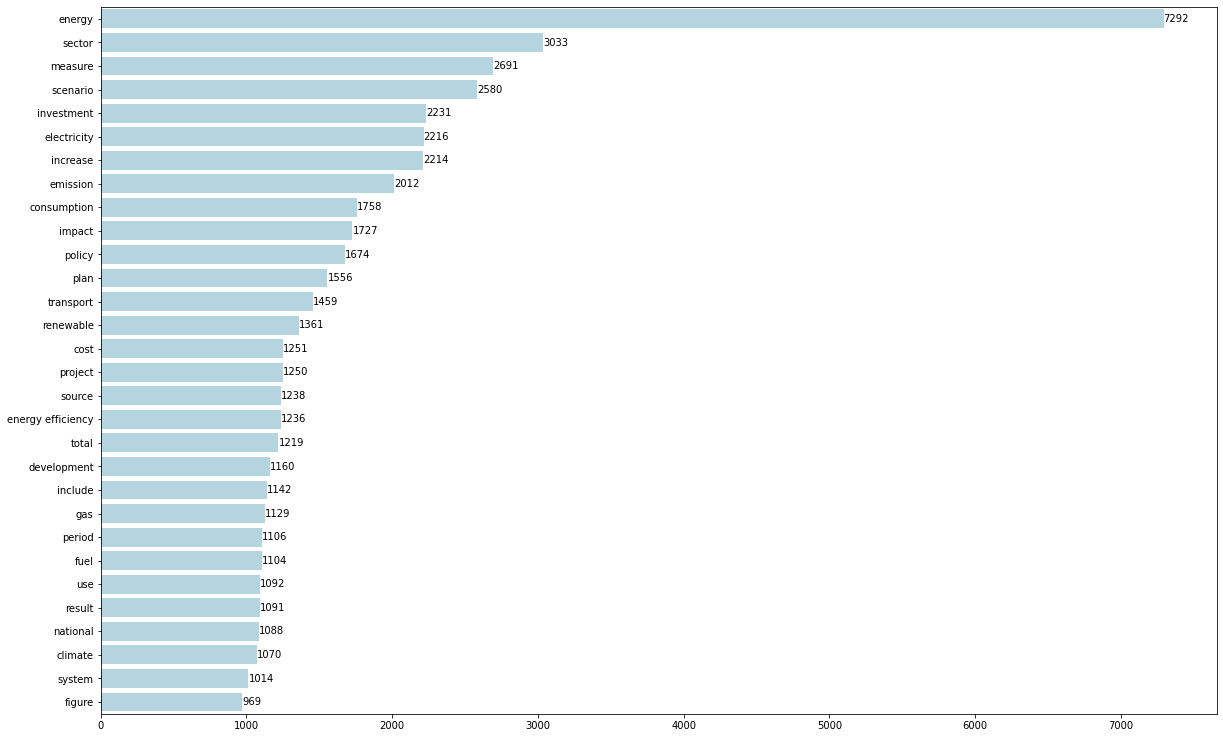

In [15]:
filter_dict = {'paragraph':paragraphs[1]}
plot_counter_lemmas(processed_df, filter_dict)

In [16]:
filtered_lemmas = processed_df.loc[(processed_df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]["lemmas"]
counter = Counter(filtered_lemmas.sum()).most_common(4)
common_words[paragraphs[1]] = [word for word, cnt in counter]

### Paragraph: Decarbonisation

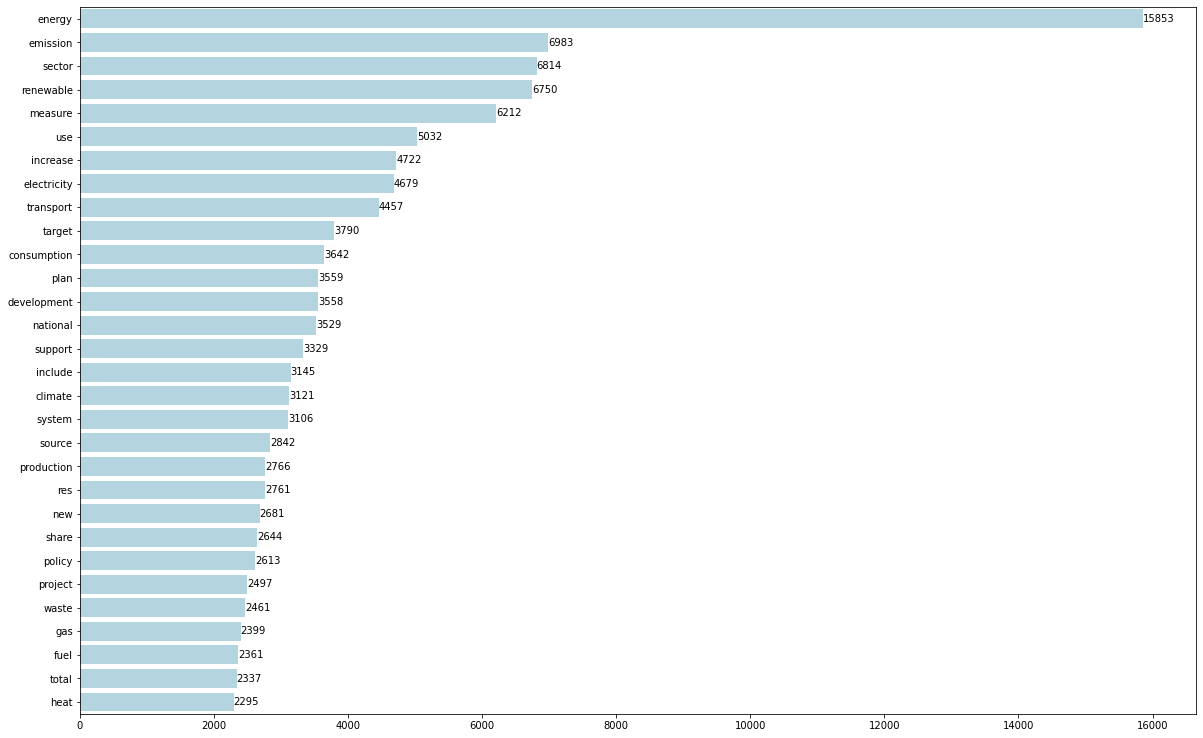

In [17]:
filter_dict = {'paragraph':paragraphs[2]}
plot_counter_lemmas(processed_df, filter_dict)

In [18]:
filtered_lemmas = processed_df.loc[(processed_df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]["lemmas"]
counter = Counter(filtered_lemmas.sum()).most_common(5)
common_words[paragraphs[2]] = [word for word, cnt in counter]

### Paragraph: Energy efficiency

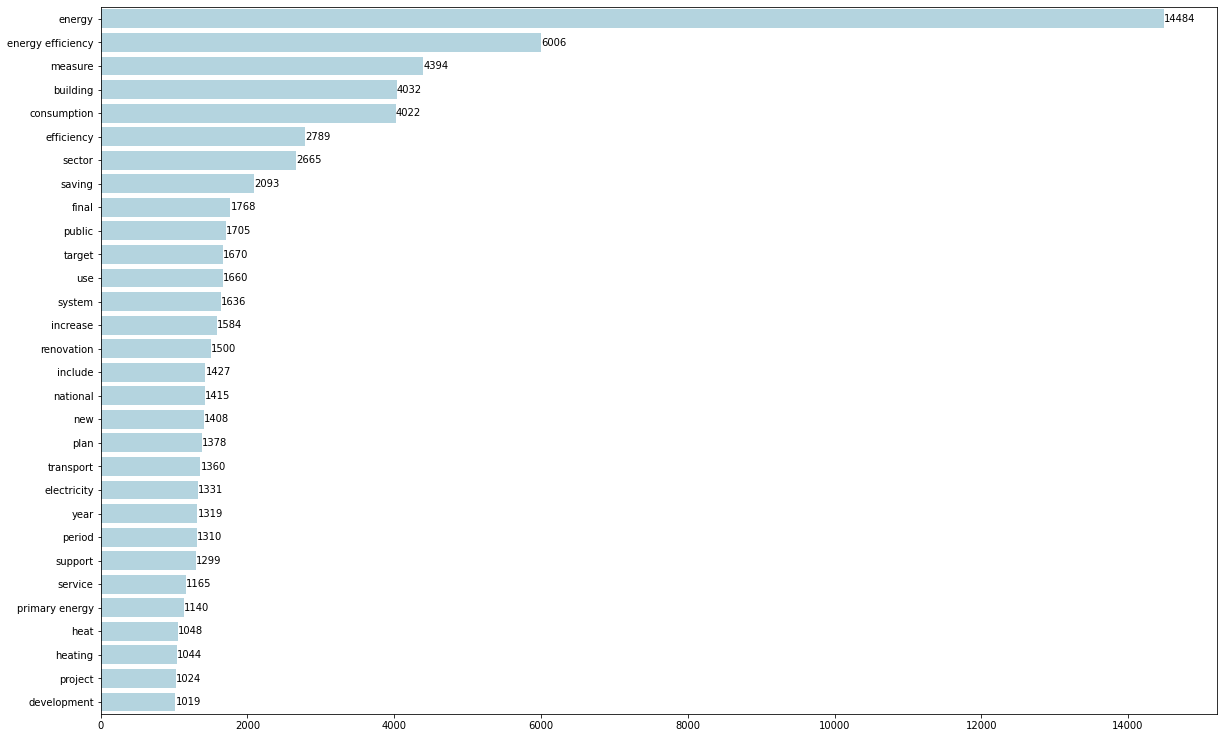

In [19]:
filter_dict = {'paragraph':paragraphs[3]}
plot_counter_lemmas(processed_df, filter_dict)

In [20]:
filtered_lemmas = processed_df.loc[(processed_df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]["lemmas"]
counter = Counter(filtered_lemmas.sum()).most_common(7)
common_words[paragraphs[3]] = [word for word, cnt in counter]

### Paragraph: Energy security

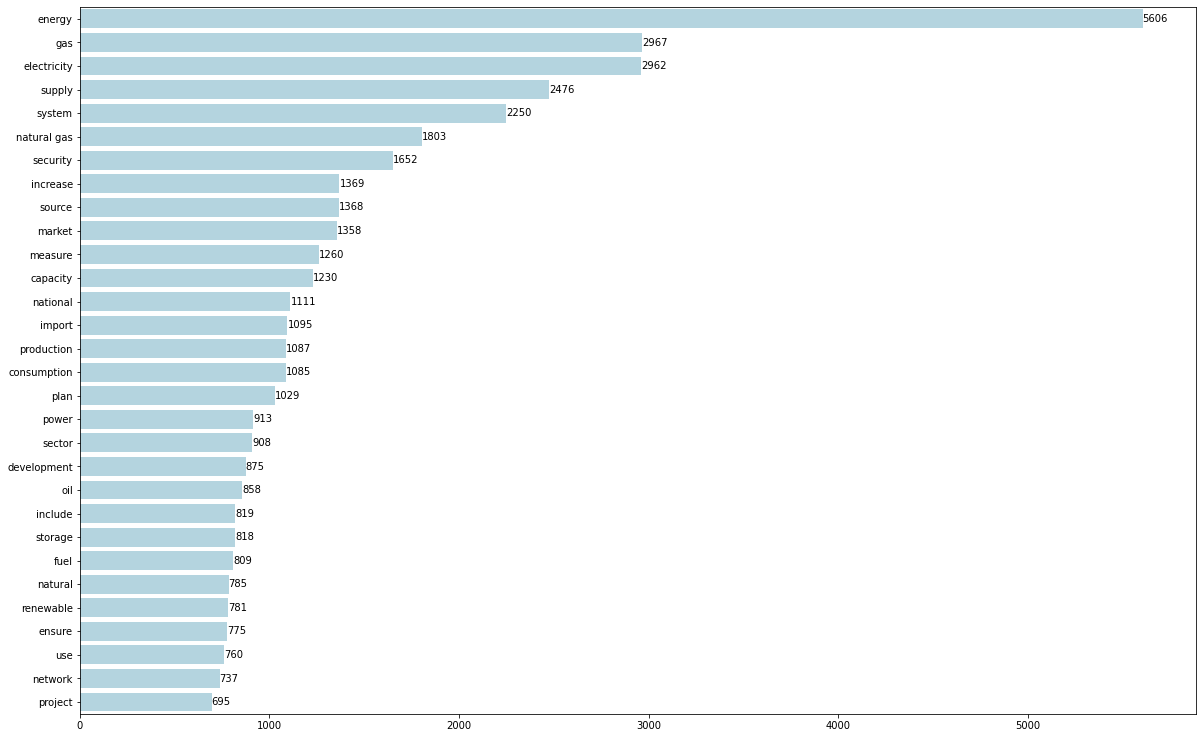

In [21]:
filter_dict = {'paragraph':paragraphs[4]}
plot_counter_lemmas(processed_df, filter_dict)

In [22]:
filtered_lemmas = processed_df.loc[(processed_df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]["lemmas"]
counter = Counter(filtered_lemmas.sum()).most_common(7)
common_words[paragraphs[4]] = [word for word, cnt in counter]

### Paragraph: Internal market

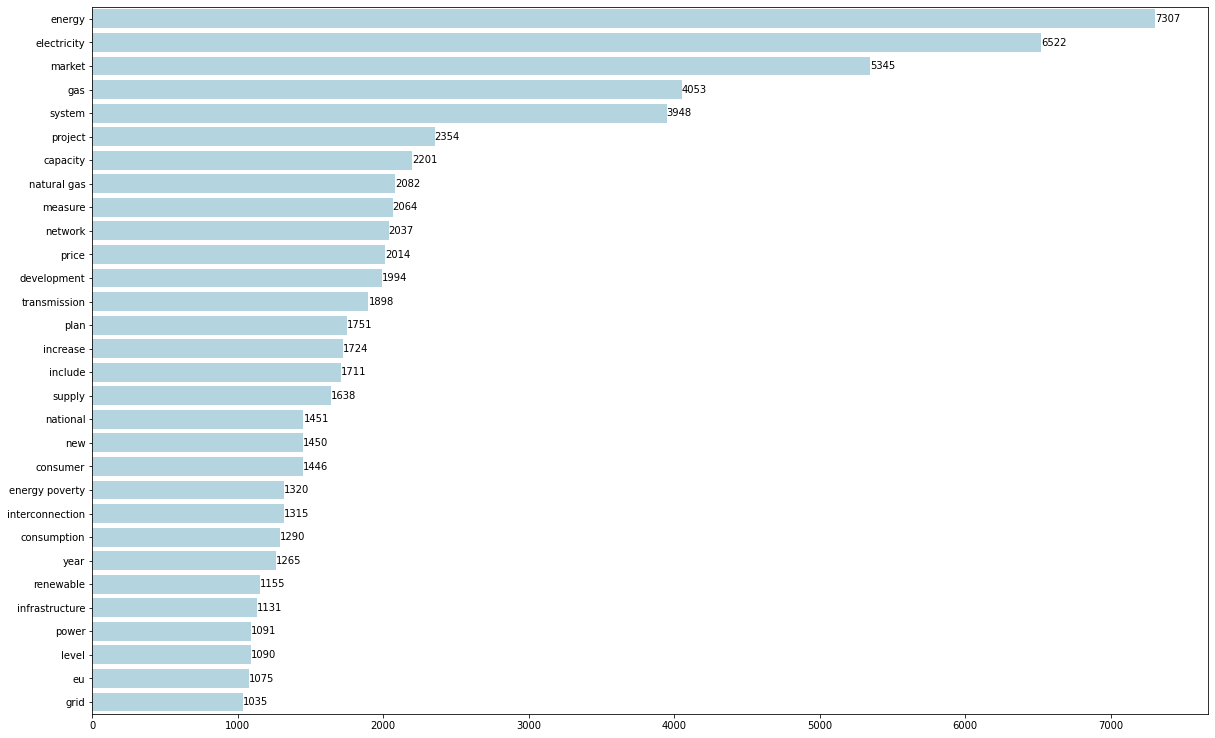

In [23]:
filter_dict = {'paragraph':paragraphs[5]}
plot_counter_lemmas(processed_df, filter_dict)

In [24]:
filtered_lemmas = processed_df.loc[(processed_df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]["lemmas"]
counter = Counter(filtered_lemmas.sum()).most_common(5)
common_words[paragraphs[5]] = [word for word, cnt in counter]

### Paragraph: R&I and Competitiveness

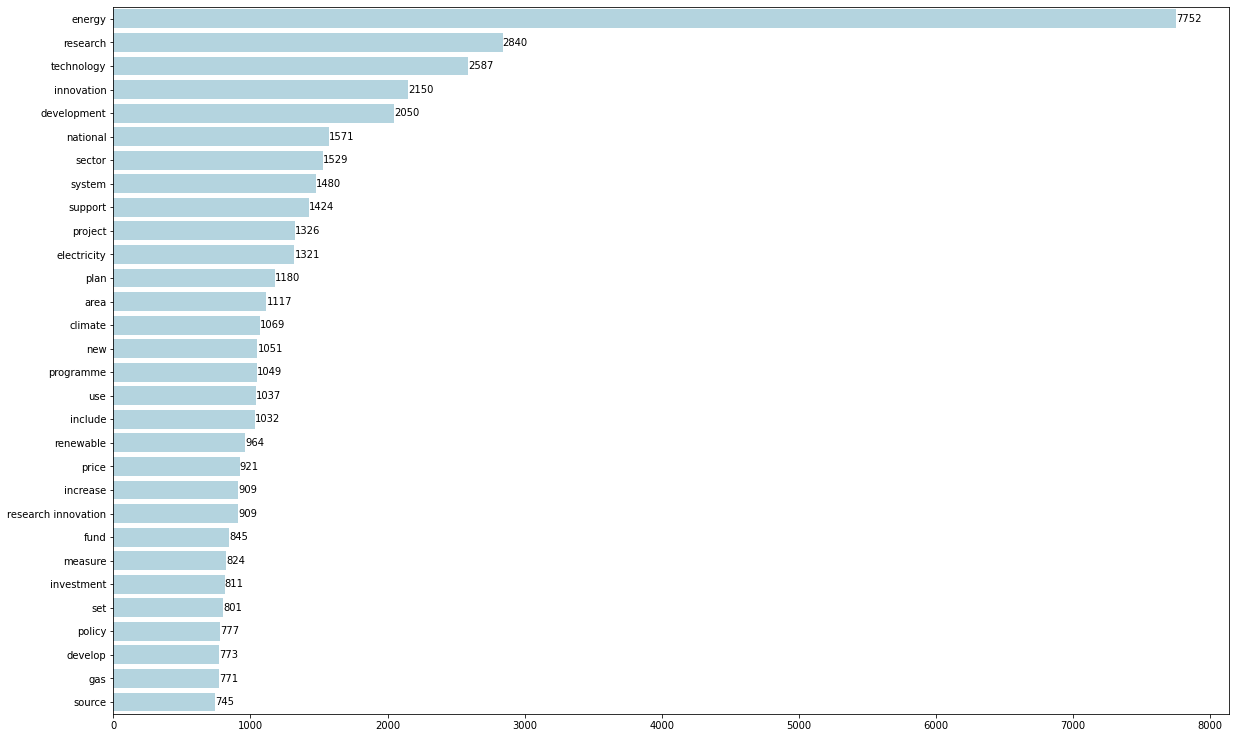

In [25]:
filter_dict = {'paragraph':paragraphs[6]}
plot_counter_lemmas(processed_df, filter_dict)

In [26]:
filtered_lemmas = processed_df.loc[(processed_df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]["lemmas"]
counter = Counter(filtered_lemmas.sum()).most_common(5)
common_words[paragraphs[6]] = [word for word, cnt in counter]

In [27]:
topic_numbers_range = (2, 11)

In [28]:
def do_pipeline(par, alpha):
    filter_dict = {'paragraph': par}
    (filtered_lemmas, models, encoded_docs, lemmas_dictionary, cvs) = check_coherence_for_topics_num(
        processed_df,
        filter_dict,
        common_words[par],
        topic_numbers_range
    )
    num_topics = find_best_topics_num(cvs, topic_numbers_range)
    lda_model = find_best_model(encoded_docs, lemmas_dictionary, cvs, topic_numbers_range, alpha=alpha)
    modeling_results, topic_probs = get_topic_probs(processed_df, filter_dict, lda_model, num_topics, encoded_docs)
    topics_by_country = topic_probs_by_column_binded(modeling_results, num_topics, column='country')
    tsne_result = tsne_dim_reduction(topics_by_country, num_topics, perplexity=10)
    tsne_result.to_csv(par.replace(" ", "_") + "_" + str(alpha) +"_probs.csv")

In [30]:
for alpha in [50, 100, 150, 200, 250]:
    for par_idx in range(7):
        do_pipeline(paragraphs[par_idx], alpha)

100%|██████████| 9/9 [01:52<00:00, 12.45s/it]


[t-SNE] Computing 26 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.216986
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.234901


C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.065903


100%|██████████| 9/9 [01:45<00:00, 11.68s/it]


[t-SNE] Computing 26 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.253543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.136711


C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.137078


100%|██████████| 9/9 [02:39<00:00, 17.73s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Latvia has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.070651
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.202057
[t-SNE] KL divergence after 1000 iterations: 0.095678


100%|██████████| 9/9 [01:42<00:00, 11.41s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.057178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.413906
[t-SNE] KL divergence after 1000 iterations: 0.108748


100%|██████████| 9/9 [01:22<00:00,  9.22s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.074270
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.307411
[t-SNE] KL divergence after 1000 iterations: 0.062392


100%|██████████| 9/9 [01:41<00:00, 11.29s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.252942
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.796234
[t-SNE] KL divergence after 1000 iterations: 0.126447


100%|██████████| 9/9 [01:26<00:00,  9.66s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.187495
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.209595
[t-SNE] KL divergence after 900 iterations: 0.127073


100%|██████████| 9/9 [01:46<00:00, 11.80s/it]


[t-SNE] Computing 26 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.326554
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.234741


C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.141150


100%|██████████| 9/9 [01:42<00:00, 11.42s/it]


[t-SNE] Computing 26 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.224504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.575790


C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.287709


100%|██████████| 9/9 [02:32<00:00, 16.97s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Latvia has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.046820
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.616390
[t-SNE] KL divergence after 1000 iterations: 0.044494


100%|██████████| 9/9 [01:39<00:00, 11.09s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.064806
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.395844
[t-SNE] KL divergence after 1000 iterations: 0.058062


100%|██████████| 9/9 [01:21<00:00,  9.09s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.089579
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.954334
[t-SNE] KL divergence after 1000 iterations: 0.101281


100%|██████████| 9/9 [01:40<00:00, 11.18s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.113753
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.152641
[t-SNE] KL divergence after 1000 iterations: 0.133323


100%|██████████| 9/9 [01:28<00:00,  9.80s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.111348
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.630360
[t-SNE] KL divergence after 1000 iterations: 0.161071


100%|██████████| 9/9 [01:46<00:00, 11.82s/it]


[t-SNE] Computing 26 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.303565
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.471062


C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.046995


100%|██████████| 9/9 [01:41<00:00, 11.23s/it]


[t-SNE] Computing 26 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.179783
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.250778


C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.154460


100%|██████████| 9/9 [02:30<00:00, 16.73s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Latvia has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.084905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.981583
[t-SNE] KL divergence after 1000 iterations: 0.052660


100%|██████████| 9/9 [01:40<00:00, 11.20s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.066762
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.897835
[t-SNE] KL divergence after 1000 iterations: 0.109668


100%|██████████| 9/9 [01:22<00:00,  9.15s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.069405
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.265717
[t-SNE] KL divergence after 1000 iterations: 0.054908


100%|██████████| 9/9 [01:44<00:00, 11.59s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.113088
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.165878
[t-SNE] KL divergence after 1000 iterations: 0.080811


100%|██████████| 9/9 [01:27<00:00,  9.69s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.099846
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.870193
[t-SNE] KL divergence after 1000 iterations: 0.108817


100%|██████████| 9/9 [01:44<00:00, 11.65s/it]


[t-SNE] Computing 26 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.145728
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.204826


C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.144231


100%|██████████| 9/9 [01:41<00:00, 11.29s/it]


[t-SNE] Computing 26 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.102361
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.138855


C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.199078


100%|██████████| 9/9 [02:31<00:00, 16.84s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Latvia has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.072591
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.926338
[t-SNE] KL divergence after 1000 iterations: 0.103243


100%|██████████| 9/9 [01:44<00:00, 11.62s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.066860
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.071442
[t-SNE] KL divergence after 1000 iterations: 0.064410


100%|██████████| 9/9 [01:24<00:00,  9.34s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.043860
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.985649
[t-SNE] KL divergence after 1000 iterations: 0.104347


100%|██████████| 9/9 [01:43<00:00, 11.45s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.085396
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.019653
[t-SNE] KL divergence after 1000 iterations: 0.059181


100%|██████████| 9/9 [01:27<00:00,  9.71s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.033194
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.997829
[t-SNE] KL divergence after 1000 iterations: 0.083519


100%|██████████| 9/9 [01:47<00:00, 11.89s/it]


[t-SNE] Computing 26 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.241473
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.183201


C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.077357


100%|██████████| 9/9 [01:42<00:00, 11.36s/it]


[t-SNE] Computing 26 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.051151
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.084049


C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.256184


100%|██████████| 9/9 [02:35<00:00, 17.28s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Latvia has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.048817
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.135048
[t-SNE] KL divergence after 1000 iterations: 0.044907


100%|██████████| 9/9 [01:41<00:00, 11.26s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.001s...
[t-SNE] Computed neighbors for 26 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.066325
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.575478
[t-SNE] KL divergence after 1000 iterations: 0.123845


100%|██████████| 9/9 [01:24<00:00,  9.42s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.029440
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.496525
[t-SNE] KL divergence after 1000 iterations: 0.094537


100%|██████████| 9/9 [01:42<00:00, 11.35s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.017958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.138451
[t-SNE] KL divergence after 1000 iterations: 0.142392


100%|██████████| 9/9 [01:28<00:00,  9.80s/it]
c:\Users\piotr\OneDrive - Politechnika Warszawska\lab\necps\policyComparison\mair-policies-comparision\topic_modeling\topic_probs.py:95: UserWarning: country - Greece has missing rows!
  warnings.warn(f"{column} - {column_val} has missing rows!")
C:\Users\piotr\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.053490
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.042286
[t-SNE] KL divergence after 1000 iterations: 0.066522
